## 1. Setup and Configuration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    confusion_matrix, 
    classification_report
)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10



## 2. Configuration Parameters

In [2]:
# Model configuration
TEST_SIZE = 0.2
CV_FOLDS = 5

# Business parameters
AVG_CUSTOMER_VALUE = 5000  # GBP
INTERVENTION_COST = 150     # GBP per customer
INTERVENTION_SUCCESS_RATE = 0.6  # 60% success rate

# Group baseline metrics (from group project report)
GROUP_BASELINE = {
    'Accuracy': 0.8545,
    'Precision': 0.8295,
    'Recall': 0.3587,
    'F1': 0.5009
}



## 3. Load and Audit Data

In [3]:
# Load the dataset
df = pd.read_csv('Churn_Modelling_Cleaned.csv')

print(df.shape)
print(df.head())

(10000, 11)
   CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0          619    France  Female   42       2       0.00              1   
1          608     Spain  Female   41       1   83807.86              1   
2          502    France  Female   42       8  159660.80              3   
3          699    France  Female   39       1       0.00              2   
4          850     Spain  Female   43       2  125510.82              1   

   HasCrCard  IsActiveMember  EstimatedSalary  Exited  
0          1               1        101348.88       1  
1          0               1        112542.58       0  
2          1               0        113931.57       1  
3          0               0         93826.63       0  
4          1               1         79084.10       0  


In [4]:
print(df.dtypes)

print(df.isnull().sum())

print(df.duplicated().sum())

CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64
0


In [5]:
# Target variable distribution
print(df['Exited'].value_counts())

print("Churn rate:")
churn_rate = df['Exited'].mean()
print(churn_rate)
print(churn_rate * 100)

Exited
0    7963
1    2037
Name: count, dtype: int64
Churn rate:
0.2037
20.369999999999997


## 4. Exploratory Data Analysis

In [6]:
print(df.describe())

        CreditScore           Age        Tenure        Balance  NumOfProducts  \
count  10000.000000  10000.000000  10000.000000   10000.000000   10000.000000   
mean     650.528800     38.921800      5.012800   76485.889288       1.530200   
std       96.653299     10.487806      2.892174   62397.405202       0.581654   
min      350.000000     18.000000      0.000000       0.000000       1.000000   
25%      584.000000     32.000000      3.000000       0.000000       1.000000   
50%      652.000000     37.000000      5.000000   97198.540000       1.000000   
75%      718.000000     44.000000      7.000000  127644.240000       2.000000   
max      850.000000     92.000000     10.000000  250898.090000       4.000000   

         HasCrCard  IsActiveMember  EstimatedSalary        Exited  
count  10000.00000    10000.000000     10000.000000  10000.000000  
mean       0.70550        0.515100    100090.239881      0.203700  
std        0.45584        0.499797     57510.492818      0.402769 

In [7]:
# Churn rate by Geography
geo_churn = df.groupby('Geography')['Exited'].agg(['mean', 'count'])
geo_churn['mean_pct'] = geo_churn['mean'] * 100
print(geo_churn)

print("Churn rate by Gender:")
gender_churn = df.groupby('Gender')['Exited'].agg(['mean', 'count'])
gender_churn['mean_pct'] = gender_churn['mean'] * 100
print(gender_churn)

               mean  count   mean_pct
Geography                            
France     0.161548   5014  16.154767
Germany    0.324432   2509  32.443204
Spain      0.166734   2477  16.673395
Churn rate by Gender:
            mean  count   mean_pct
Gender                            
Female  0.250715   4543  25.071539
Male    0.164559   5457  16.455928


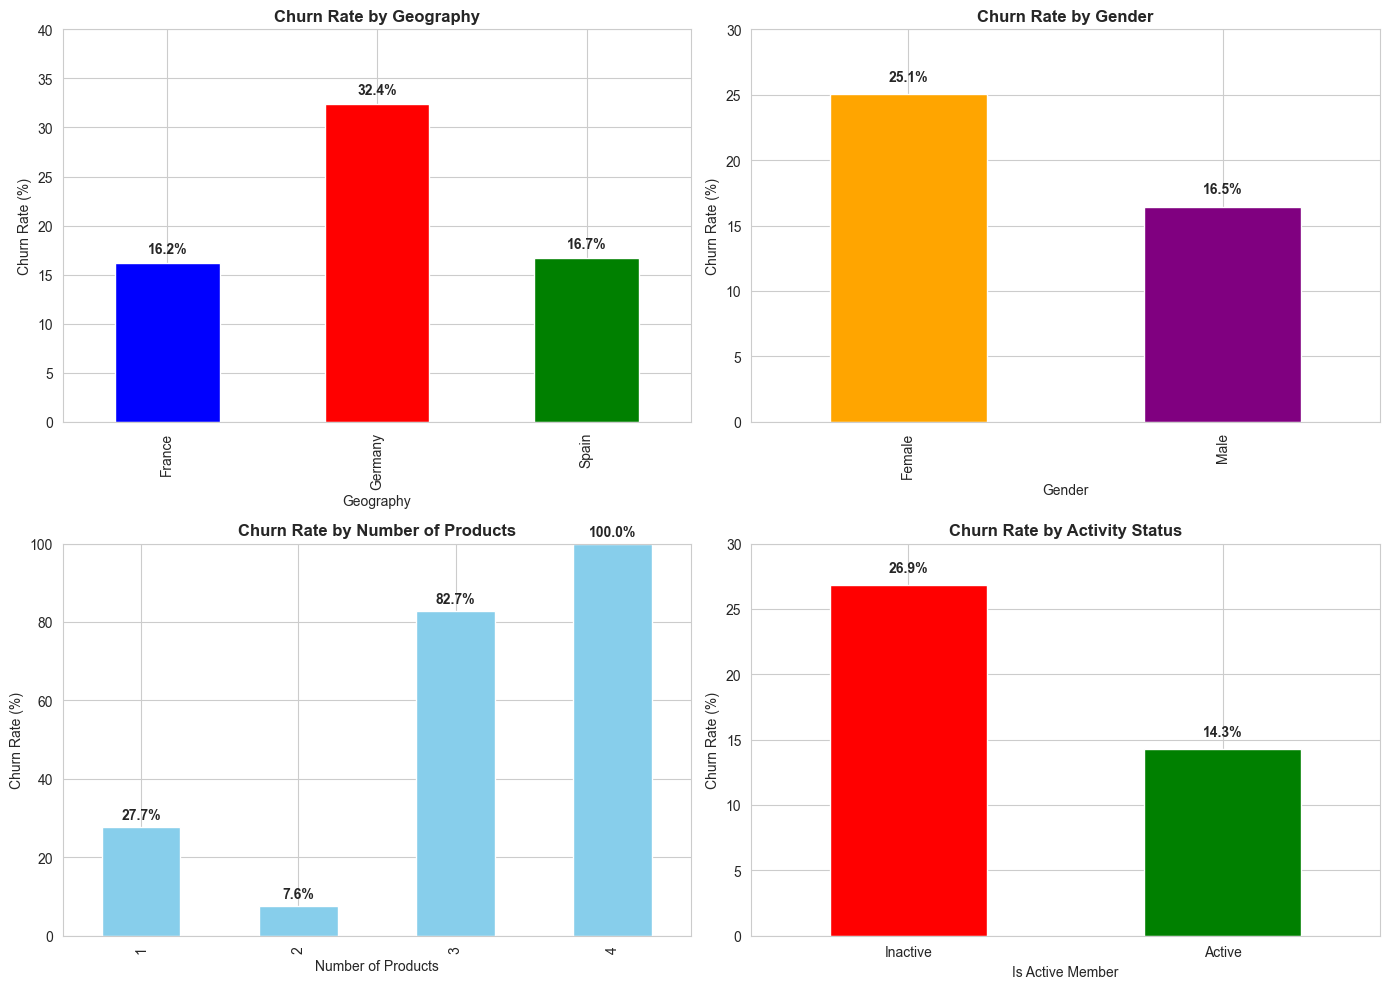

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Geography
ax1 = axes[0, 0]
geo_churn_pct = df.groupby('Geography')['Exited'].mean() * 100
geo_churn_pct.plot(kind='bar', ax=ax1, color=['blue', 'red', 'green'])
ax1.set_title('Churn Rate by Geography', fontweight='bold')
ax1.set_ylabel('Churn Rate (%)')
ax1.set_xlabel('Geography')
ax1.set_ylim([0, 40])
for i, v in enumerate(geo_churn_pct):
    ax1.text(i, v + 1, str(round(v, 1)) + '%', ha='center', fontweight='bold')

# Gender
ax2 = axes[0, 1]
gender_churn_pct = df.groupby('Gender')['Exited'].mean() * 100
gender_churn_pct.plot(kind='bar', ax=ax2, color=['orange', 'purple'])
ax2.set_title('Churn Rate by Gender', fontweight='bold')
ax2.set_ylabel('Churn Rate (%)')
ax2.set_xlabel('Gender')
ax2.set_ylim([0, 30])
for i, v in enumerate(gender_churn_pct):
    ax2.text(i, v + 1, str(round(v, 1)) + '%', ha='center', fontweight='bold')

# Number of Products
ax3 = axes[1, 0]
products_churn_pct = df.groupby('NumOfProducts')['Exited'].mean() * 100
products_churn_pct.plot(kind='bar', ax=ax3, color='skyblue')
ax3.set_title('Churn Rate by Number of Products', fontweight='bold')
ax3.set_ylabel('Churn Rate (%)')
ax3.set_xlabel('Number of Products')
ax3.set_ylim([0, 100])
for i, v in enumerate(products_churn_pct):
    ax3.text(i, v + 2, str(round(v, 1)) + '%', ha='center', fontweight='bold')

# Activity Status
ax4 = axes[1, 1]
active_churn_pct = df.groupby('IsActiveMember')['Exited'].mean() * 100
active_churn_pct.plot(kind='bar', ax=ax4, color=['red', 'green'])
ax4.set_title('Churn Rate by Activity Status', fontweight='bold')
ax4.set_ylabel('Churn Rate (%)')
ax4.set_xlabel('Is Active Member')
ax4.set_xticklabels(['Inactive', 'Active'], rotation=0)
ax4.set_ylim([0, 30])
for i, v in enumerate(active_churn_pct):
    ax4.text(i, v + 1, str(round(v, 1)) + '%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()


## 5. Feature Engineering

### 5.1 Recreate Group Project Features

In [9]:
# Features from group project
df['BalanceIsZero'] = (df['Balance'] == 0).astype(int)
df['Age_Balance_Interaction'] = df['Age'] * df['Balance']
df['AgeBin'] = pd.cut(df['Age'], 
                      bins=[18, 25, 35, 45, 60, 100],
                      labels=['18-25', '26-35', '36-45', '46-60', '60+'])

print(df[['BalanceIsZero', 'Age_Balance_Interaction', 'AgeBin']].head())

   BalanceIsZero  Age_Balance_Interaction AgeBin
0              1                     0.00  36-45
1              0               3436122.26  36-45
2              0               6705753.60  36-45
3              1                     0.00  36-45
4              0               5396965.26  36-45


### 5.2 Create New Individual Features


In [10]:
# Tenure-based features
df['IsNewCustomer'] = (df['Tenure'] <= 2).astype(int)
df['IsLongTermCustomer'] = (df['Tenure'] >= 8).astype(int)
df['TenureAgeRatio'] = df['Tenure'] / (df['Age'] + 1)

# Product engagement features
df['HasSingleProduct'] = (df['NumOfProducts'] == 1).astype(int)
df['HasMultipleProducts'] = (df['NumOfProducts'] >= 3).astype(int)

# Financial health indicators
df['BalanceToSalaryRatio'] = df['Balance'] / (df['EstimatedSalary'] + 1)
df['IsHighBalance'] = (df['Balance'] > df['Balance'].quantile(0.75)).astype(int)
df['IsLowBalance'] = (df['Balance'] < df['Balance'].quantile(0.25)).astype(int)

# Credit risk features
df['IsGoodCredit'] = (df['CreditScore'] >= 670).astype(int)
df['IsPoorCredit'] = (df['CreditScore'] < 580).astype(int)

# Geographic risk (Germany shows 32.4% churn vs 16.2% in France)
df['IsHighRiskGeography'] = (df['Geography'] == 'Germany').astype(int)

# Age risk (46-60 age group shows 51.1% churn rate)
df['IsHighRiskAge'] = ((df['Age'] >= 46) & (df['Age'] <= 60)).astype(int)

# Composite risk score
df['RiskScore'] = (
    df['IsHighRiskGeography'] * 2.0 +
    df['IsHighRiskAge'] * 2.0 +
    df['HasSingleProduct'] * 1.5 +
    (1 - df['IsActiveMember']) * 1.5 +
    df['BalanceIsZero'] * 1.0
)


print(df['RiskScore'].describe())

count    10000.000000
mean         2.682850
std          1.495966
min          0.000000
25%          1.500000
50%          2.500000
75%          3.500000
max          7.000000
Name: RiskScore, dtype: float64


### 5.3 Analyze Feature Correlation with Churn

In [11]:
new_features = [
    'IsNewCustomer', 
    'HasSingleProduct', 
    'IsHighRiskGeography', 
    'IsHighRiskAge', 
    'RiskScore',
    'BalanceToSalaryRatio'
]

correlations = df[new_features + ['Exited']].corr()['Exited'].drop('Exited')
correlations_sorted = correlations.sort_values(ascending=False)
print(correlations_sorted)

RiskScore               0.400608
IsHighRiskAge           0.339065
HasSingleProduct        0.185447
IsHighRiskGeography     0.173488
BalanceToSalaryRatio    0.025963
IsNewCustomer           0.011225
Name: Exited, dtype: float64


## 6. Data Preparation for Modeling

In [12]:
# One-hot encode categorical variables
df_encoded = pd.get_dummies(
    df, 
    columns=['Geography', 'Gender', 'AgeBin'], 
    drop_first=False
)

print(df_encoded.shape)

(10000, 34)


In [13]:
# Separate features and target
X = df_encoded.drop(['Exited'], axis=1)
y = df_encoded['Exited']


print(X.shape)
print(y.shape)
print(X.shape[1])

(10000, 33)
(10000,)
33


## 7. Train-Test Split

In [14]:
# Split data with stratification (same as group project)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_SEED, 
    stratify=y
)

print(X_train.shape)
print(X_test.shape)

print(y_train.value_counts())
print(y_test.value_counts())

(8000, 33)
(2000, 33)
Exited
0    6370
1    1630
Name: count, dtype: int64
Exited
0    1593
1     407
Name: count, dtype: int64


## 8. Baseline Model (Group Project Reproduction)

In [15]:
# Reproduce group baseline with same hyperparameters
baseline_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=RANDOM_SEED
)

baseline_model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [16]:
# Predictions
y_pred_baseline = baseline_model.predict(X_test)

# Calculate metrics
baseline_acc = accuracy_score(y_test, y_pred_baseline)
baseline_prec = precision_score(y_test, y_pred_baseline)
baseline_rec = recall_score(y_test, y_pred_baseline)
baseline_f1 = f1_score(y_test, y_pred_baseline)

print("Accuracy:", baseline_acc)
print("Precision:", baseline_prec)
print("Recall:", baseline_rec)
print("F1-Score:", baseline_f1)

Accuracy: 0.856
Precision: 0.7931034482758621
Recall: 0.3955773955773956
F1-Score: 0.5278688524590164


## 9. Model Improvement with Hyperparameter Tuning


In [17]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}


print("Total combinations:", 
      len(param_grid['n_estimators']) * 
      len(param_grid['max_depth']) * 
      len(param_grid['min_samples_split']) * 
      len(param_grid['min_samples_leaf']) * 
      len(param_grid['max_features']))

Total combinations: 216


In [18]:
# Setup stratified cross-validation
cv_strategy = StratifiedKFold(
    n_splits=CV_FOLDS, 
    shuffle=True, 
    random_state=RANDOM_SEED
)

# Initialize GridSearchCV with F1
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=RANDOM_SEED),
    param_grid=param_grid,
    cv=cv_strategy,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)


In [19]:
# Fit grid search
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'max_depth': [5, 10, ...], 'max_features': ['sqrt', 'log2'], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], ...}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,100


In [20]:
# Best parameters and cross-validation score
print(grid_search.best_params_)

print(grid_search.best_score_)

{'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
0.580172599011443


## 10. Improved Model Evaluation

In [21]:
# Get best model
best_model = grid_search.best_estimator_

# Predictions on test set
y_pred_improved = best_model.predict(X_test)

# Calculate performance metrics
improved_acc = accuracy_score(y_test, y_pred_improved)
improved_prec = precision_score(y_test, y_pred_improved)
improved_rec = recall_score(y_test, y_pred_improved)
improved_f1 = f1_score(y_test, y_pred_improved)

print("Accuracy:", improved_acc)
print("Precision:", improved_prec)
print("Recall:", improved_rec)
print("F1-Score:", improved_f1)

Accuracy: 0.868
Precision: 0.7894736842105263
Recall: 0.47911547911547914
F1-Score: 0.5963302752293578


## 11. Model Comparison and Performance Gains

In [22]:
comparison = pd.DataFrame({
    'Model': ['Group Baseline', 'Improved Model'],
    'Accuracy': [baseline_acc, improved_acc],
    'Precision': [baseline_prec, improved_prec],
    'Recall': [baseline_rec, improved_rec],
    'F1-Score': [baseline_f1, improved_f1]
})

print(comparison)


print("Accuracy improvement:", (improved_acc - baseline_acc) * 100)
print("Precision improvement:", (improved_prec - baseline_prec) * 100)
print("Recall improvement:", (improved_rec - baseline_rec) * 100)
print("F1-Score improvement:", (improved_f1 - baseline_f1) * 100)


print("Recall relative improvement:", ((improved_rec - baseline_rec) / baseline_rec) * 100)

            Model  Accuracy  Precision    Recall  F1-Score
0  Group Baseline     0.856   0.793103  0.395577  0.527869
1  Improved Model     0.868   0.789474  0.479115  0.596330
Accuracy improvement: 1.200000000000001
Precision improvement: -0.3629764065335772
Recall improvement: 8.353808353808356
F1-Score improvement: 6.84614227703414
Recall relative improvement: 21.118012422360255


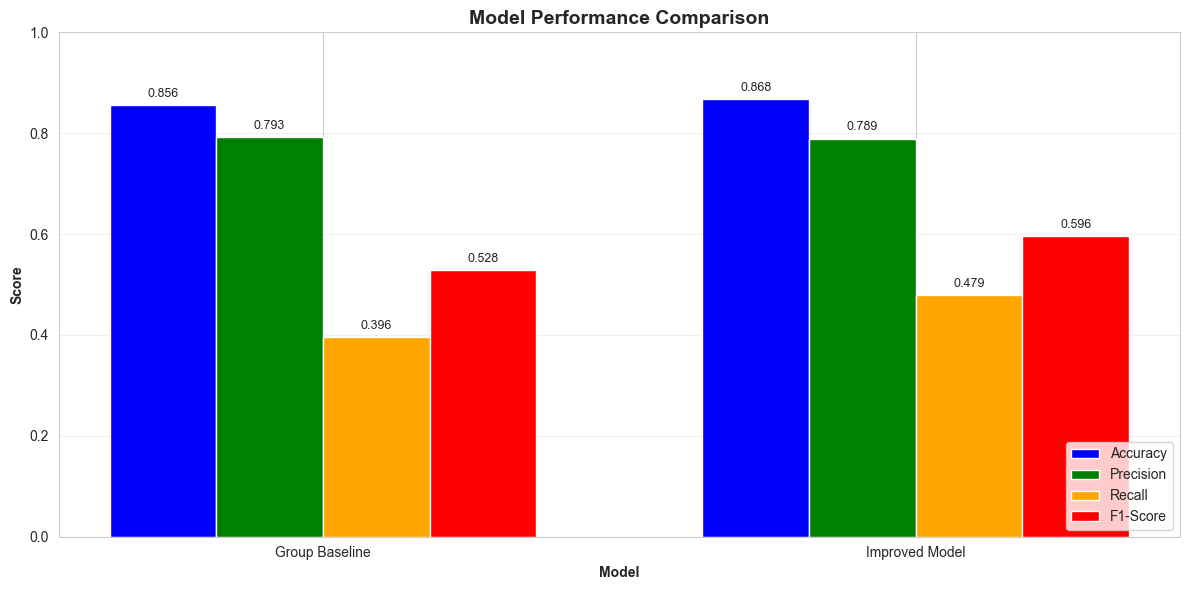

In [23]:
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(comparison))
width = 0.18

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['blue', 'green', 'orange', 'red']

for i, metric in enumerate(metrics):
    values = comparison[metric].values
    bars = ax.bar(x + i*width, values, width, label=metric, color=colors[i])
    
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                str(round(val, 3)), ha='center', va='bottom', fontsize=9)

ax.set_xlabel('Model', fontweight='bold')
ax.set_ylabel('Score', fontweight='bold')
ax.set_title('Model Performance Comparison', fontweight='bold', fontsize=14)
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(comparison['Model'])
ax.legend(loc='lower right')
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()



## 12. Confusion Matrix Analysis

In [24]:
# Calculate confusion matrices
cm_baseline = confusion_matrix(y_test, y_pred_baseline)
cm_improved = confusion_matrix(y_test, y_pred_improved)

print(cm_baseline)
print(cm_improved)

# Calculate specific metrics from confusion matrix
tn_base, fp_base, fn_base, tp_base = cm_baseline.ravel()
tn_imp, fp_imp, fn_imp, tp_imp = cm_improved.ravel()

print("Baseline - True Positives (Correctly identified churners):")
print(tp_base)
print("Improved - True Positives (Correctly identified churners):")
print(tp_imp)
print("Additional churners identified:", tp_imp - tp_base)

[[1551   42]
 [ 246  161]]
[[1541   52]
 [ 212  195]]
Baseline - True Positives (Correctly identified churners):
161
Improved - True Positives (Correctly identified churners):
195
Additional churners identified: 34


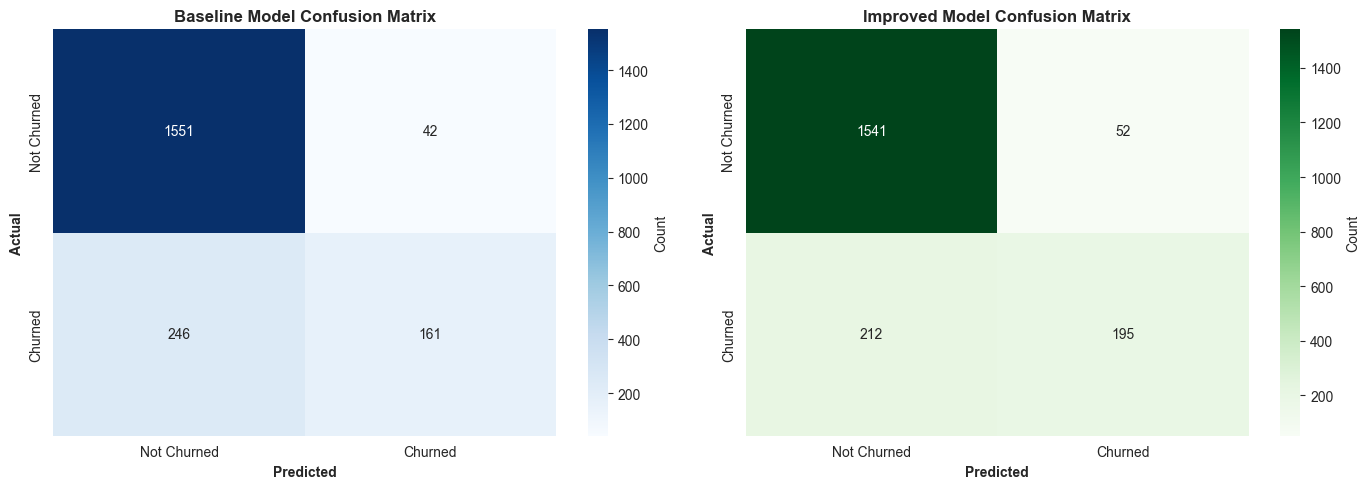

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Baseline
ax1 = axes[0]
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['Not Churned', 'Churned'],
            yticklabels=['Not Churned', 'Churned'],
            cbar_kws={'label': 'Count'})
ax1.set_title('Baseline Model Confusion Matrix', fontweight='bold', fontsize=12)
ax1.set_ylabel('Actual', fontweight='bold')
ax1.set_xlabel('Predicted', fontweight='bold')

# Improved
ax2 = axes[1]
sns.heatmap(cm_improved, annot=True, fmt='d', cmap='Greens', ax=ax2,
            xticklabels=['Not Churned', 'Churned'],
            yticklabels=['Not Churned', 'Churned'],
            cbar_kws={'label': 'Count'})
ax2.set_title('Improved Model Confusion Matrix', fontweight='bold', fontsize=12)
ax2.set_ylabel('Actual', fontweight='bold')
ax2.set_xlabel('Predicted', fontweight='bold')

plt.tight_layout()
plt.show()

## 13. Feature Importance Analysis

In [26]:
importances = best_model.feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

print("Top 15 Most Important Features:")
print(importance_df.head(15))

Top 15 Most Important Features:
                    Feature  Importance
1                       Age    0.094808
22                RiskScore    0.092424
9   Age_Balance_Interaction    0.075107
7           EstimatedSalary    0.071769
0               CreditScore    0.071638
3                   Balance    0.068478
12           TenureAgeRatio    0.063927
4             NumOfProducts    0.062247
15     BalanceToSalaryRatio    0.058932
14      HasMultipleProducts    0.053287
31             AgeBin_46-60    0.036472
2                    Tenure    0.036300
21            IsHighRiskAge    0.034519
6            IsActiveMember    0.022637
13         HasSingleProduct    0.020834


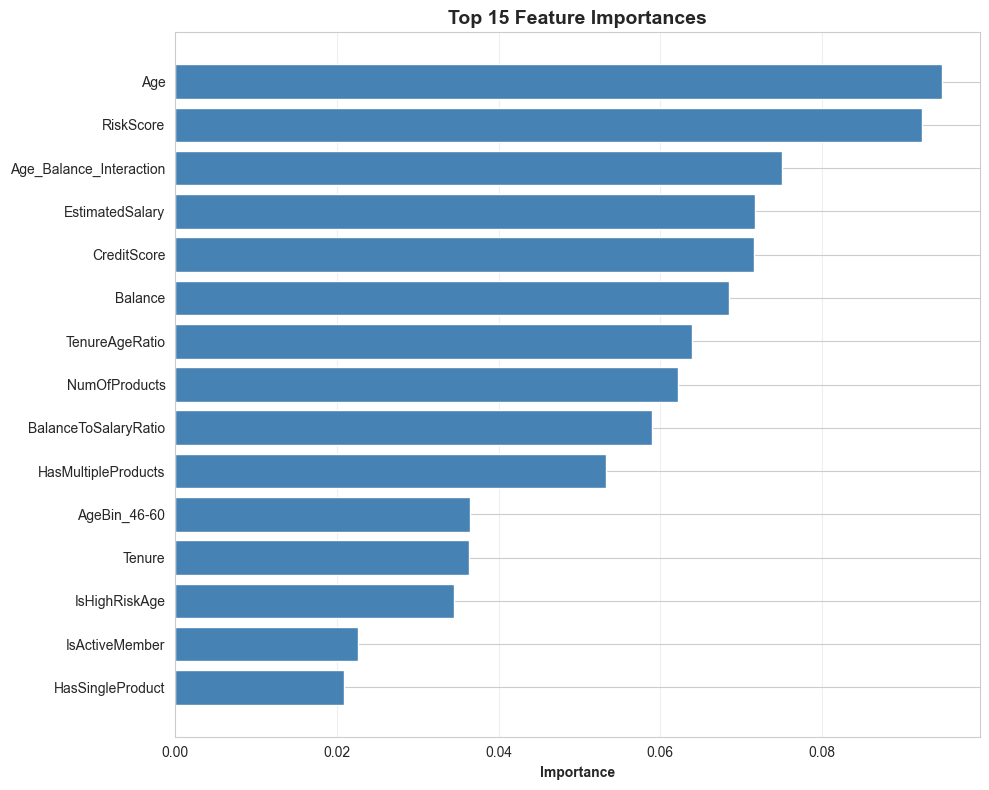

In [27]:
top_features = importance_df.head(15)

plt.figure(figsize=(10, 8))
plt.barh(range(len(top_features)), top_features['Importance'], color='steelblue')
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importance', fontweight='bold')
plt.title('Top 15 Feature Importances', fontweight='bold', fontsize=14)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


## 14. Fairness Analysis

### 14.1 Gender Fairness Assessment

In [28]:
# Prepare test data with original features for demographic analysis
test_indices = X_test.index
df_test = df.loc[test_indices].copy()
df_test['Predicted'] = y_pred_improved
df_test['Actual'] = y_test.values

print(df_test[['Gender', 'Geography', 'Predicted', 'Actual']].head())

      Gender Geography  Predicted  Actual
5702    Male    France          0       0
3667    Male   Germany          0       0
1617  Female     Spain          0       0
5673    Male     Spain          0       0
4272  Female     Spain          0       0


In [29]:
# Gender fairness analysis
gender_fairness = []

for gender in ['Male', 'Female']:
    gender_data = df_test[df_test['Gender'] == gender]
    
    acc = accuracy_score(gender_data['Actual'], gender_data['Predicted'])
    prec = precision_score(gender_data['Actual'], gender_data['Predicted'], zero_division=0)
    rec = recall_score(gender_data['Actual'], gender_data['Predicted'], zero_division=0)
    f1 = f1_score(gender_data['Actual'], gender_data['Predicted'], zero_division=0)
    
    # Calculate False Negative Rate
    cm = confusion_matrix(gender_data['Actual'], gender_data['Predicted'])
    if cm.shape == (2, 2):
        fn = cm[1, 0]
        tp = cm[1, 1]
        fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    else:
        fnr = 0
    
    gender_fairness.append({
        'Gender': gender,
        'Sample_Size': len(gender_data),
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1': f1,
        'FNR': fnr
    })

gender_df = pd.DataFrame(gender_fairness)
print("Gender Fairness Analysis:")
print(gender_df)


gender_acc_diff = abs(gender_df.iloc[0]['Accuracy'] - gender_df.iloc[1]['Accuracy'])
print("Gender Accuracy Disparity:")
print(gender_acc_diff)
print(gender_acc_diff * 100)

Gender Fairness Analysis:
   Gender  Sample_Size  Accuracy  Precision    Recall        F1       FNR
0    Male         1070  0.893458   0.806122  0.454023  0.580882  0.545977
1  Female          930  0.838710   0.778523  0.497854  0.607330  0.502146
Gender Accuracy Disparity:
0.05474826650587883
5.474826650587882


### 14.2 Geographic Fairness Assessment

In [30]:
geo_fairness = []

for geography in ['France', 'Germany', 'Spain']:
    geo_data = df_test[df_test['Geography'] == geography]
    
    acc = accuracy_score(geo_data['Actual'], geo_data['Predicted'])
    prec = precision_score(geo_data['Actual'], geo_data['Predicted'], zero_division=0)
    rec = recall_score(geo_data['Actual'], geo_data['Predicted'], zero_division=0)
    f1 = f1_score(geo_data['Actual'], geo_data['Predicted'], zero_division=0)
    
    # Calculate False Negative Rate
    cm = confusion_matrix(geo_data['Actual'], geo_data['Predicted'])
    if cm.shape == (2, 2):
        fn = cm[1, 0]
        tp = cm[1, 1]
        fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    else:
        fnr = 0
    
    geo_fairness.append({
        'Geography': geography,
        'Sample_Size': len(geo_data),
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1': f1,
        'FNR': fnr
    })

geo_df = pd.DataFrame(geo_fairness)
print("Geographic Fairness Analysis:")
print(geo_df)

# Calculate disparity
geo_acc_diff = geo_df['Accuracy'].max() - geo_df['Accuracy'].min()
print("Geographic Accuracy Disparity:")
print(geo_acc_diff)
print(geo_acc_diff * 100)

Geographic Fairness Analysis:
  Geography  Sample_Size  Accuracy  Precision    Recall        F1       FNR
0    France         1021  0.873653   0.767442  0.377143  0.505747  0.622857
1   Germany          504  0.831349   0.770492  0.622517  0.688645  0.377483
2     Spain          475  0.894737   0.897436  0.432099  0.583333  0.567901
Geographic Accuracy Disparity:
0.06338763575605677
6.338763575605677


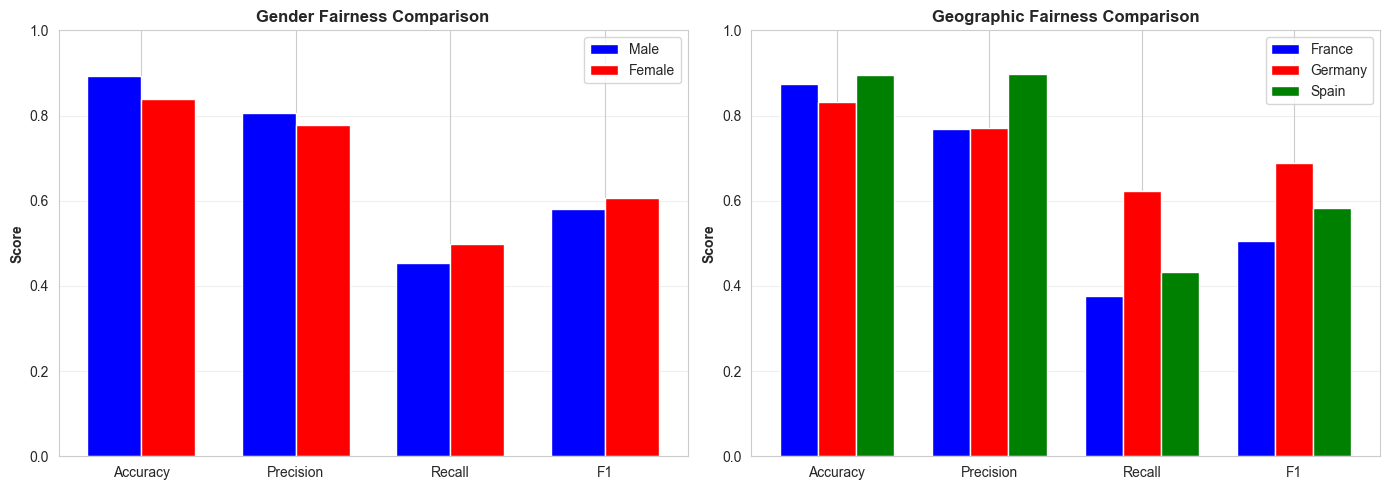

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gender fairness
ax1 = axes[0]
metrics_plot = ['Accuracy', 'Precision', 'Recall', 'F1']
x = np.arange(len(metrics_plot))
width = 0.35

male_vals = [gender_df[gender_df['Gender']=='Male'][m].values[0] for m in metrics_plot]
female_vals = [gender_df[gender_df['Gender']=='Female'][m].values[0] for m in metrics_plot]

ax1.bar(x - width/2, male_vals, width, label='Male', color='blue')
ax1.bar(x + width/2, female_vals, width, label='Female', color='red')
ax1.set_ylabel('Score', fontweight='bold')
ax1.set_title('Gender Fairness Comparison', fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics_plot)
ax1.legend()
ax1.set_ylim([0, 1])
ax1.grid(axis='y', alpha=0.3)

# Geographic fairness
ax2 = axes[1]
x = np.arange(len(metrics_plot))
width = 0.25

france_vals = [geo_df[geo_df['Geography']=='France'][m].values[0] for m in metrics_plot]
germany_vals = [geo_df[geo_df['Geography']=='Germany'][m].values[0] for m in metrics_plot]
spain_vals = [geo_df[geo_df['Geography']=='Spain'][m].values[0] for m in metrics_plot]

ax2.bar(x - width, france_vals, width, label='France', color='blue')
ax2.bar(x, germany_vals, width, label='Germany', color='red')
ax2.bar(x + width, spain_vals, width, label='Spain', color='green')
ax2.set_ylabel('Score', fontweight='bold')
ax2.set_title('Geographic Fairness Comparison', fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(metrics_plot)
ax2.legend()
ax2.set_ylim([0, 1])
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


## 15. Business Impact Analysis

### 15.1 Targeting Strategy - Top 20% Highest Risk Customers

In [32]:
# Get prediction probabilities
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
df_test['Probability'] = y_pred_proba

# Sort by predicted probability
df_test_sorted = df_test.sort_values('Probability', ascending=False)

# Target top 20% highest risk customers
n_targeted = int(len(df_test_sorted) * 0.20)
top_customers = df_test_sorted.head(n_targeted)

print("Targeting Strategy: Top 20% Highest Risk")
print("Number of customers targeted:", n_targeted)
print("Actual churners in targeted group:")
churners_captured = top_customers['Actual'].sum()
print(churners_captured)

print("Total churners in test set:")
total_churners = df_test['Actual'].sum()
print(total_churners)

print("Capture rate:")
capture_rate = churners_captured / total_churners
print(capture_rate)
print(capture_rate * 100)

print("Precision at top 20%:")
precision_at_20 = top_customers['Actual'].mean()
print(precision_at_20)
print(precision_at_20 * 100)

Targeting Strategy: Top 20% Highest Risk
Number of customers targeted: 400
Actual churners in targeted group:
247
Total churners in test set:
407
Capture rate:
0.6068796068796068
60.68796068796068
Precision at top 20%:
0.6175
61.75000000000001


### 15.2 Financial Impact Calculation

In [33]:
# Calculate financial metrics for test set
prevented_churns_test = int(churners_captured * INTERVENTION_SUCCESS_RATE)
revenue_saved_test = prevented_churns_test * AVG_CUSTOMER_VALUE
costs_test = n_targeted * INTERVENTION_COST
net_benefit_test = revenue_saved_test - costs_test
roi_test = net_benefit_test / costs_test if costs_test > 0 else 0

print("Prevented churns:", prevented_churns_test)
print("Revenue saved (GBP):", revenue_saved_test)
print("Intervention costs (GBP):", costs_test)
print("Net benefit (GBP):", net_benefit_test)
print("ROI:", roi_test)

Prevented churns: 148
Revenue saved (GBP): 740000
Intervention costs (GBP): 60000
Net benefit (GBP): 680000
ROI: 11.333333333333334


### 15.3 Annual Projection to Full Customer Base

In [34]:
# Project to full customer base of 10,000
total_customers = 10000
scale_factor = total_customers / len(df_test)

# Annual projections
annual_targeted = int(n_targeted * scale_factor)
annual_churners_captured = int(churners_captured * scale_factor)
annual_prevented = int(prevented_churns_test * scale_factor)
annual_revenue = int(revenue_saved_test * scale_factor)
annual_costs = int(costs_test * scale_factor)
annual_net = annual_revenue - annual_costs
annual_roi = annual_net / annual_costs if annual_costs > 0 else 0

print("Customers targeted:", annual_targeted)
print("Churners captured:", annual_churners_captured)
print("Prevented churns:", annual_prevented)
print("Annual revenue saved (GBP):", annual_revenue)
print("Annual costs (GBP):", annual_costs)
print("Annual net benefit (GBP):", annual_net)
print("Annual ROI:", annual_roi)

Customers targeted: 2000
Churners captured: 1235
Prevented churns: 740
Annual revenue saved (GBP): 3700000
Annual costs (GBP): 300000
Annual net benefit (GBP): 3400000
Annual ROI: 11.333333333333334


In [35]:
# Calculate churn rate reduction
current_churn_rate = y.mean()
current_annual_churners = int(total_customers * current_churn_rate)
new_annual_churners = current_annual_churners - annual_prevented
new_churn_rate = new_annual_churners / total_customers
churn_reduction = current_churn_rate - new_churn_rate

print("Current churn rate:", current_churn_rate)
print("Current annual churners:", current_annual_churners)
print("New annual churners:", new_annual_churners)
print("New churn rate:", new_churn_rate)
print("Churn reduction (percentage points):", churn_reduction)
print("Churn reduction (percent):", churn_reduction * 100)

Current churn rate: 0.2037
Current annual churners: 2037
New annual churners: 1297
New churn rate: 0.1297
Churn reduction (percentage points): 0.07399999999999998
Churn reduction (percent): 7.399999999999999


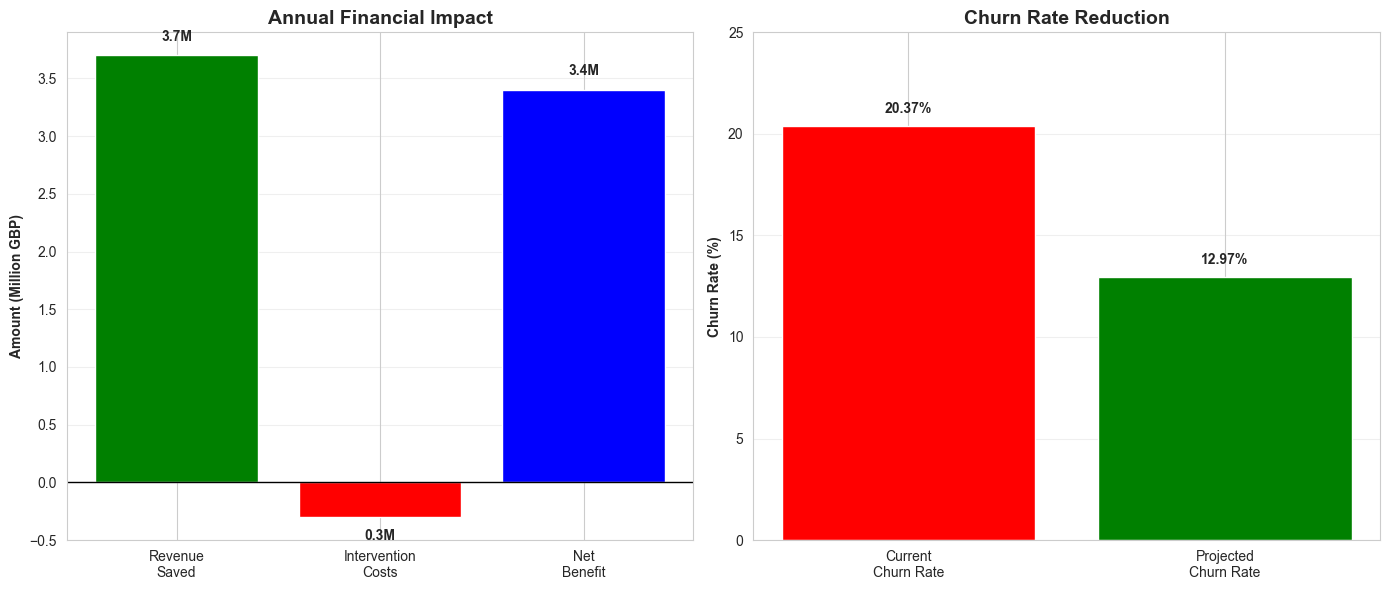

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Financial impact
ax1 = axes[0]
categories = ['Revenue\nSaved', 'Intervention\nCosts', 'Net\nBenefit']
values = [annual_revenue/1000000, -annual_costs/1000000, annual_net/1000000]
colors = ['green', 'red', 'blue']

bars = ax1.bar(categories, values, color=colors)
ax1.set_ylabel('Amount (Million GBP)', fontweight='bold')
ax1.set_title('Annual Financial Impact', fontweight='bold', fontsize=14)
ax1.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax1.grid(axis='y', alpha=0.3)

for bar, val in zip(bars, values):
    height = bar.get_height()
    label = str(round(abs(val), 2)) + 'M'
    if val >= 0:
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1, label,
                ha='center', va='bottom', fontweight='bold')
    else:
        ax1.text(bar.get_x() + bar.get_width()/2., height - 0.1, label,
                ha='center', va='top', fontweight='bold')

# Churn rate comparison
ax2 = axes[1]
churn_categories = ['Current\nChurn Rate', 'Projected\nChurn Rate']
churn_values = [current_churn_rate * 100, new_churn_rate * 100]
ax2.bar(churn_categories, churn_values, color=['red', 'green'])
ax2.set_ylabel('Churn Rate (%)', fontweight='bold')
ax2.set_title('Churn Rate Reduction', fontweight='bold', fontsize=14)
ax2.set_ylim([0, 25])
ax2.grid(axis='y', alpha=0.3)

for i, val in enumerate(churn_values):
    ax2.text(i, val + 0.5, str(round(val, 2)) + '%', 
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

